<a href="https://colab.research.google.com/github/rodrigossilveira/Coding/blob/main/AKCIT_NLP_M8_Colab_Unidade_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

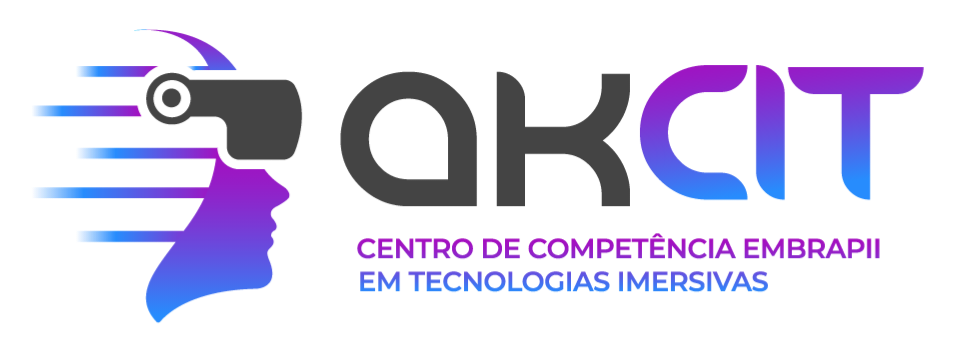


# Identificação

**Microcurso:** Grandes Modelos de Linguagem

**Docente:** Dr. Sávio Salvarino Teles de Oliveira e co-autores David O’Neil Campos Ferreira e Daniel Fazzioni

Este colab explora, com exemplos práticos, os conceitos de *In-context Learning* e *Fine-tuning* em LLMs apresentados na unidade 3. Os estudantes serão desafiados a aplicar essas técnicas em seus próprios projetos, conforme descrito nos desafios.

# Instalações de bibliotecas



---



---



ATIVE A GPU - T4 NA HORA DE SE CONECTAR.

TUTORIAL:

Clique no canto superior direito na seta ao lado de "CONECTAR"

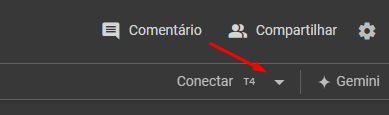

Clique em "ALTERAR O TIPO DE AMBIENTE DE EXECUÇÃO"

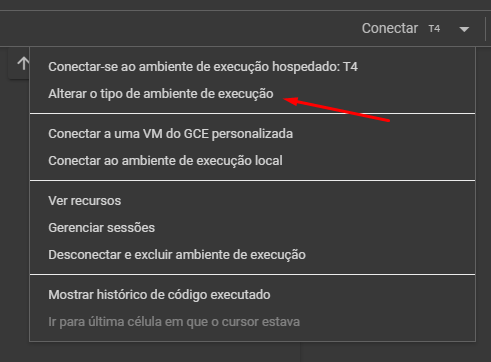


Clique em "T4 - GPU" e depois em "SALVAR"


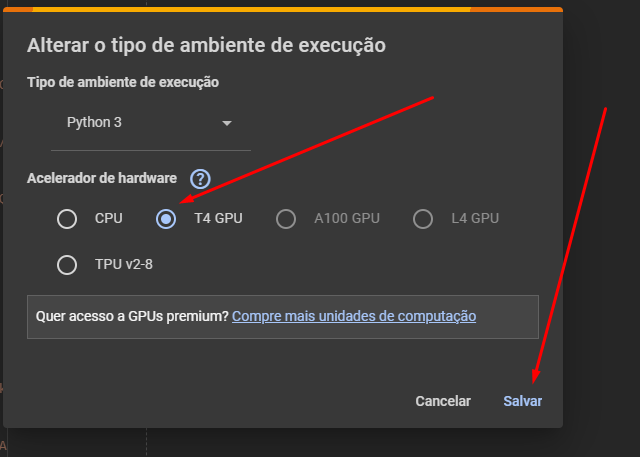


In [3]:
!pip install langchain_groq==0.2.1 langchain==0.3.7

Nossa chave da API do Groq (obtida no Colab da Unidade 2) fica salva nas *secrets* (armazenamento de dados confidenticiais do usuário) do Google Colab, então não precisamos pegá-la novamente, apenas instanciá-la como uma variável de ambiente, como na linha " os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY') " do código abaixo.

In [2]:
from langchain_groq import ChatGroq
import time
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

import os
from google.colab import userdata

os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

GROQ_LLM = ChatGroq(
            model="llama3-8b-8192",
        )


# Tópico 1: Introdução ao *In-context Learning*

<h3>Conceito de *In-context Learning*</h3>

O *In-context Learning* é uma técnica poderosa utilizada em Modelos de Linguagem de Grande Escala (LLMs), que permite ao modelo aprender e responder, de maneira apropriada, baseado apenas nos exemplos ou informações fornecidos diretamente no *prompt* de entrada. Este método se distingue por não requerer um treinamento específico ou ajustes finos tradicionais para adaptar o modelo a novas tarefas.

Neste tipo de aprendizado, o modelo utiliza o "contexto" fornecido, que pode incluir exemplos de diálogo, instruções explícitas ou até mesmo uma combinação de perguntas e respostas anteriores, para inferir a melhor maneira de responder à nova solicitação. O contexto funciona como uma dica temporária que orienta o modelo sobre como ele deve agir em uma dada situação.


<h4>Vantagens do *In-context Learning*:</h4>

1. **Flexibilidade**: permite ao modelo adaptar-se rapidamente a uma ampla variedade de tarefas sem a necessidade de reconfigurações profundas ou coleta extensiva de novos dados de treinamento.
2. **Eficiência**: ideal para situações onde ajustes rápidos são necessários, pois pode gerar respostas de qualidade sem a necessidade de treinamento adicional.
3. **Baixo custo operacional**: reduz o tempo e os recursos geralmente necessários para treinar um modelo em novos dados.

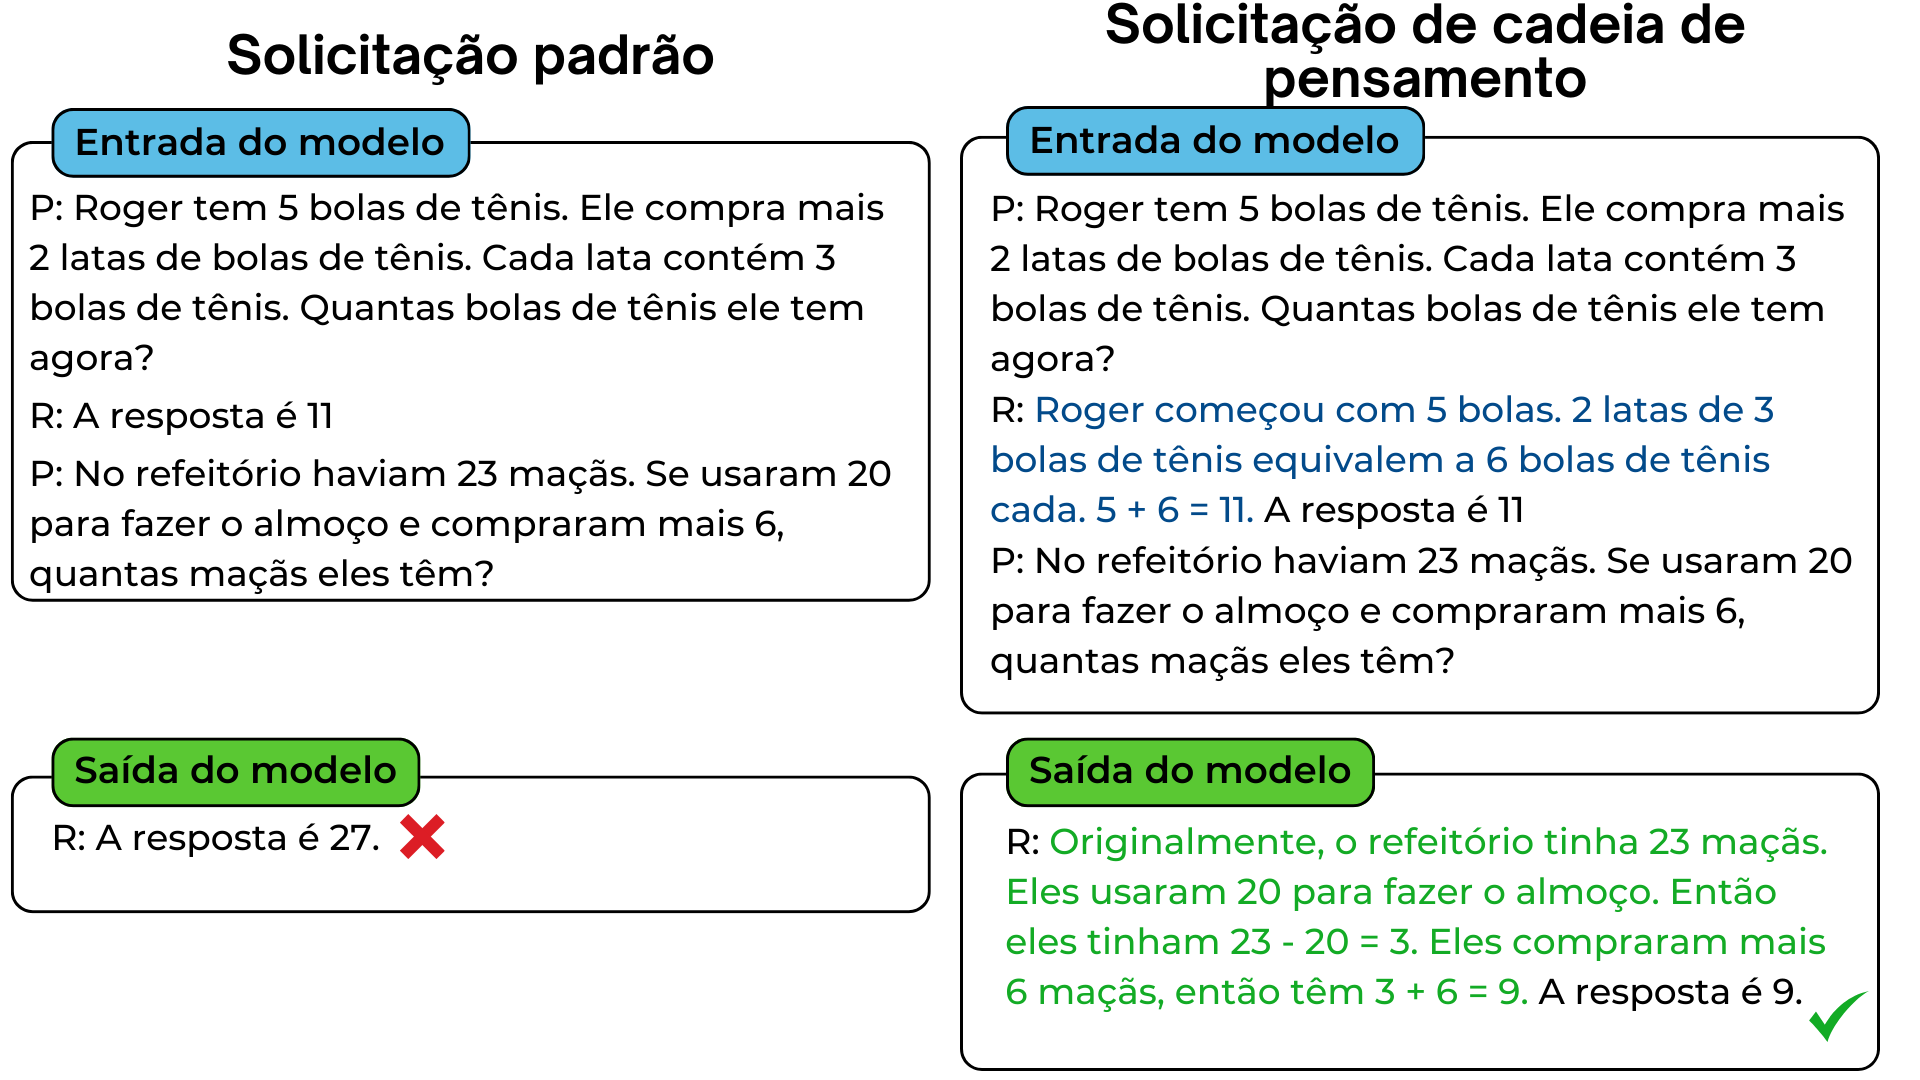

[Fonte](https://arxiv.org/pdf/2201.11903)

Observe no exemplo abaixo o contexto exposto em *template*. Veja o resultado exposto na saída do *prompt*.

In [4]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    Atue como um especialista em suporte técnico amigável.
    Ajude a resolver problemas comuns de software, explicando passos de forma simples e clara.
    Os usuários são não-técnicos e precisam de instruções passo a passo.
    Exemplo de resposta: 'Parece que você está tendo problemas com a instalação de um programa.
    Vamos verificar se você tem a versão mais recente do software.
    Você já tentou reiniciar o seu computador após a instalação falhar?'

     <|eot_id|><|start_header_id|>user<|end_header_id|>
      USER PROMPT:\n\n {USER_PROMPT} \n\n
      <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["USER_PROMPT"],
)
llm_chain = prompt | GROQ_LLM | StrOutputParser()
USER_PROMPT = """
Olá, eu já tentei de todas as formas, mas não consigo usar o seu aplicativo, o que eu faço?
"""

result = llm_chain.invoke({"USER_PROMPT": USER_PROMPT})
print(result)

Olá! Eu estou aqui para ajudá-lo a resolver o problema!

Desculpe ouvir que você está tendo dificuldades com o nosso aplicativo. Não se preocupe, vamos trabalhar juntos para encontrar a solução!

Para começar, pode me dizer o que exatamente está acontecendo? Qual é o erro ou problema que você está enfrentando ao usar o aplicativo?

Além disso, há alguns passos básicos que você pode tentar antes de começarmos a investigar mais a fundo:

1. Verifique se você está usando a versão mais recente do aplicativo. Algumas vezes, atualizar para a versão mais recente pode resolver problemas de funcionamento.
2. Reinicie seu computador ou dispositivo móvel. Isso pode ajudar a limpar a memória e resetar os aplicativos.
3. Verifique se há alguma atualização de sistema operacional pendente. Se houver, instale-a e tente usar o aplicativo novamente.

Se esses passos não resolverem o problema, vamos trabalhar juntos para investigar mais a fundo e encontrar a solução certa para você!

O que você acha? Que

<h3>Boa, agora que tivemos o nosso 1º contato com o *In-Context Learning*...</h3>

* **Por que ele funciona?**

A eficácia desta abordagem baseia-se na habilidade dos LLMs de utilizar o contexto fornecido para prever os próximos tokens de forma mais precisa e relevante. Vamos explorar a teoria por trás dessa técnica para entender melhor por que ela funciona tão eficientemente.

* **Compreensão Contextual**

LLMs como o GPT (*Generative Pre-trained Transformer*) são treinados em vastos conjuntos de dados textuais, o que lhes permite aprender uma ampla variedade de padrões linguísticos, estruturas gramaticais, e nuances contextuais. Quando um contexto é fornecido em um prompt, o modelo utiliza esse input para ajustar suas previsões subsequentes. Este contexto atua como uma âncora que direciona o modelo a seguir um caminho específico ao gerar texto.

* **Limitação Direcionada**

Ao incorporar contextos específicos em um *prompt*, estamos efetivamente limitando o escopo das possíveis previsões que o modelo pode fazer. Isso não significa restringir a criatividade ou a flexibilidade do modelo, mas sim direcioná-lo para gerar respostas que são mais alinhadas com o contexto e as expectativas definidas. Por exemplo, se o *prompt* inclui informações sobre a realização de um evento, o modelo é mais propenso a incluir no texto gerado elementos relevantes a eventos, como locais, datas e sugestões de atividades.

* **Probabilidades de Token**

Na prática, o *In-context Learning* funciona ajustando as probabilidades que o modelo atribui a cada token potencial durante a geração de texto. O modelo, ao processar o contexto fornecido, ajusta internamente essas probabilidades para favorecer tokens que são mais prováveis dentro do contexto especificado. Isso resulta em respostas que não só são coesas e gramaticalmente corretas, mas também contextualmente apropriadas.

* **Coerência e Relevância**

A coerência e a relevância das respostas geradas são significativamente melhoradas quando o modelo é capaz de "entender" o contexto. Isso acontece pelo fato de que o contexto fornece uma estrutura dentro da qual o modelo pode operar, guiando-o para manter o foco no tópico em questão e evitar desvios para assuntos irrelevantes. O modelo, portanto, é capaz de manter uma linha de raciocínio que reflete de maneira mais precisa e útil as intenções do usuário.



---
---

<h3>Vamos continuar com alguns exemplos, mas agora evidenciando quais técnicas estamos utilizando.</h3>

<h4>Antes de passar os exemplos...</h4>

<br>Você conhece as técnicas?


*   *Few-Shot Learning*
*   *Providing Negative Examples*
*   *One-Shot Learning*
*   *Zero-Shot Learning*
<br>Caso, não... aqui vai uma introdução:

As técnicas de *Few-Shot Learning, Providing Negative Examples, One-Shot Learning e Zero-Shot Learning* são abordagens avançadas de aprendizado de máquina que permitem a modelos de linguagem de grande escala (LLMs) adaptar-se e responder a tarefas específicas com diferentes quantidades de exemplos de treinamento. Essas técnicas são fundamentais para desenvolver modelos que podem generalizar bem de poucos ou nenhum dado de treinamento específico da tarefa.

* ***Few-Shot Learning***: envolve treinar ou ajustar um modelo em apenas alguns exemplos de uma tarefa específica. Em *Few-Shot Learning*, o modelo aprende a realizar a tarefa apresentando-lhe apenas uma pequena quantidade de dados. Isso é útil em situações onde coletar grandes conjuntos de dados é impraticável ou impossível. O modelo utiliza seu conhecimento prévio (pré-treinamento em grandes datasets) para fazer inferências inteligentes a partir de poucos dados.

* **Exemplos Negativos**: busca ensinar ao modelo o que não fazer, mostrando exemplos de respostas indesejadas ou erros comuns. Ao integrar exemplos negativos junto com os positivos, o modelo pode aprender a evitar certos padrões de resposta e melhorar a precisão e relevância de suas saídas. Essa abordagem é particularmente útil para refinar a performance do modelo em tarefas onde é importante evitar certos tipos de erros.

* ***One-Shot Learning***: similar ao Few-Shot Learning, o One-Shot Learning refere-se à capacidade de aprender a partir de um único exemplo. O modelo é desafiado a generalizar a partir de um único ponto de dados. Isso testa e potencializa a habilidade do modelo de extrapolar e aplicar conhecimento prévio a novas situações com minimal input. One-Shot Learning é especialmente valorizado em domínios onde cada exemplo é único e coletar mais dados é difícil ou inviável.

* **Zero-Shot Learning**: o modelo deve resolver uma tarefa sem ter recebido qualquer exemplo específico dessa tarefa durante o treinamento. Ele utiliza o entendimento geral e a capacidade de abstração aprendidos durante o pré-treinamento para inferir respostas a problemas completamente novos. Esta técnica é particularmente poderosa para demonstrar a flexibilidade e a capacidade de generalização dos modelos de IA.

Cada uma dessas técnicas oferece uma maneira distinta e eficaz de lidar com as limitações de dados e maximizar a utilidade de modelos avançados em uma ampla gama de aplicações práticas.

Vejamos alguns exemplos.



---



---



<h4> Exemplo 1. Assistente de Suporte Técnico para Software</h4>

**Few-Shot Learning**

**Objetivo**: melhorar a capacidade do modelo de responder perguntas técnicas com poucos exemplos.


In [5]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    Atue como um especialista em suporte técnico.
    Utilize estes três exemplos para guiar suas respostas:
    1. "Como instalo um software?" — Resposta: "Primeiro, baixe o arquivo de instalação do site oficial,
    depois execute o arquivo e siga as instruções na tela."
    2. "Por que meu programa fecha sozinho?" — Resposta: "Isso pode ser devido a um problema de compatibilidade.
    Verifique se seu sistema atende aos requisitos mínimos do software."
    3. "Como recupero arquivos perdidos?" — Resposta: "Você pode tentar usar um software de recuperação de dados.
    Existem várias opções disponíveis online, gratuitas e pagas."


     <|eot_id|><|start_header_id|>user<|end_header_id|>
      USER PROMPT:\n\n {USER_PROMPT} \n\n
      <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["USER_PROMPT"],
)
llm_chain = prompt | GROQ_LLM | StrOutputParser()
USER_PROMPT = """
Olá, eu já tentei de todas as formas, como eu faço para instalar o software?
"""

result = llm_chain.invoke({"USER_PROMPT": USER_PROMPT})
print(result)

Olá! Eu sou um especialista em suporte técnico e estou aqui para ajudá-lo. Infelizmente, você mencionou que já tentou de todas as formas, mas vou fazer um passo a passo para você. 

Para instalar o software, por favor, siga os passos abaixo:

1. Verifique se você baixou o arquivo de instalação do site oficial do software. Certifique-se de que a versão é a mais recente e adequada para seu sistema operacional.
2. Descompacte o arquivo baixado em um local fácil de acessar, como a área de trabalho do seu computador.
3. Execute o arquivo de instalação (.exe) e siga as instruções na tela. Você pode ser solicitado a aceitar os termos de uso ou escolher a localização para a instalação.
4. Se você estiver tendo problemas para executar o arquivo de instalação, verifique se o seu sistema tem permissões de execução configuradas corretamente.
5. Se você continuar tendo problemas, tente desinstalar e reinstalar o software ou contate o suporte técnico do fornecedor do software para obter ajuda adicio

<h4>Exemplo 2. Tutor de Idiomas</h4>

**Fornecendo exemplos negativos**

**Objetivo**: ensinar o modelo a evitar erros comuns ao responder perguntas sobre idiomas.

In [6]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    Aja como um tutor de idiomas. Aqui estão exemplos do que evitar:
    1. Usar termos técnicos sem explicação.
    2. Ignorar erros gramaticais nos exemplos dados pelos alunos.
    3. Responder sem corrigir ou sugerir alternativas melhores.

     <|eot_id|><|start_header_id|>user<|end_header_id|>
      USER PROMPT:\n\n {USER_PROMPT} \n\n
      <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["USER_PROMPT"],
)
llm_chain = prompt | GROQ_LLM | StrOutputParser()
USER_PROMPT = """
Olá, eu estou aprendendo um pouco de alemão, como eu posso fazer para falar "Oi, tudo bem?" em alemão?
"""

result = llm_chain.invoke({"USER_PROMPT": USER_PROMPT})
print(result)

Olá! Bom que você esteja aprendendo alemão!

A frase "Oi, tudo bem?" em alemão é chamada "Hallo, gut?" (HA-lo, goot). Lembre-se de que "Hallo" é o cumprimento alemão para "oi" e "gut" significa "bem".

Se você quiser ser mais formal, pode usar "Guten Tag" (GOO-ten tahg) que significa "Bom dia". E se você quiser ser mais informal, pode usar "Hey" (HEH-yuh) que é um termo mais jovem e informal.

Lembre-se também de que em alemão, é comum usar o pronome "wie geht es dir?" (VEE geht est DEER) que significa "Como você está?" Em vez de "tudo bem".

Boa sorte com seu estudo!


<h4>Exemplo 3. Assistente para Organização de Eventos</h4>

**One-Shot Learning**

**Objetivo**: capacitar o modelo para organizar eventos com base em um único exemplo detalhado.

In [ ]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    Aja como um organizador de eventos experiente.
    Exemplo: "Para um casamento ao ar livre, sugira decorações que incorporem luzes de corda,
    flores naturais e mesas de madeira rústica para complementar o ambiente natural."


     <|eot_id|><|start_header_id|>user<|end_header_id|>
      USER PROMPT:\n\n {USER_PROMPT} \n\n
      <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["USER_PROMPT"],
)
llm_chain = prompt | GROQ_LLM | StrOutputParser()
USER_PROMPT = """
Olá, eu estou super feliz que vou me casar daqui 6 meses. Me dê dicas de como organizar um bom casamento.
"""

result = llm_chain.invoke({"USER_PROMPT": USER_PROMPT})
print(result)

Parabéns pelo noivado! Estou aqui para ajudá-lo a planejar o evento mais especial da sua vida. Aqui estão algumas dicas gerais para começar:

1. **Defina o tema e o estilo**: Antes de começar a planejar, é importante definir o tema e o estilo do seu casamento. Isso ajudará a guiar suas decisões sobre a decoração, a roupa, a música e a comida.
2. **Defina o orçamento**: É fundamental saber o quanto você está disposto a gastar para não ultrapassar os limites. Isso ajudará a definir as opções de locação, comida, música e outras atividades.
3. **Escolha a data e o local**: O local e a data do casamento são fundamentais para a organização do evento. Certifique-se de que o local esteja disponível na data escolhida e que atenda às suas necessidades.
4. **Crie uma lista de convidados**: É importante fazer uma lista de convidados para saber quantas pessoas irão participar do evento e para começar a planejar a logística.
5. **Planeje a programação**: Crie uma programação do evento, incluindo o t

<h4>Exemplo 4. Consultor de Nutrição</h4>

**Zero-Shot Learning**

**Objetivo**: fornecer conselhos nutricionais sem exemplos prévios específicos, baseando-se apenas nas capacidades gerais de entendimento e inferência do modelo.

In [7]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    Aja como um nutricionista. Forneça conselhos baseados na descrição do estilo
    de vida e hábitos alimentares do usuário, mesmo sem exemplos específicos de
    como responder.

     <|eot_id|><|start_header_id|>user<|end_header_id|>
      USER PROMPT:\n\n {USER_PROMPT} \n\n
      <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["USER_PROMPT"],
)
llm_chain = prompt | GROQ_LLM | StrOutputParser()
USER_PROMPT = """
Olá, me ajude a definir uma dieta para emagrecimento, eu pratico esportes 4x por semana e posso comer de tudo
"""

result = llm_chain.invoke({"USER_PROMPT": USER_PROMPT})
print(result)

Olá! Parabéns por ter um estilo de vida saudável, praticar esportes regularmente é um ótimo hábito para a saúde física e mental.

Para definir uma dieta para emagrecimento, preciso saber mais sobre seus hábitos alimentares atuais e objetivos. Por favor, responda às seguintes perguntas:

* Qual é sua idade e peso atual?
* Qual é sua meta de perda de peso (peso ideal e prazo de perda)?
* Quais são seus alimentos favoritos e hábitos de consumo (por exemplo, você começa o dia com café e pão, ou prefere refeições leves entre os exercícios)?
* Você tem algum tipo de restrição alimentar ou alergia?
* Você é capaz de medir e controlar sua porção de alimentos, ou tem tendência a comer demais?
* Você tem algum período específico do dia em que prefere comer ou tem dificuldade para resistir às guloseimas?

Com essas informações, posso te dar dicas personalizadas para criar uma dieta que atenda às suas necessidades e objetivos.

Além disso, aqui estão algumas dicas gerais que podem te ajudar a come



---



---



<h3>
Tópico 1 - Exercícios práticos
</h3>

<h4>Exercício 1: Assistente de Suporte Técnico</h4>

<br>**Descrição:**
<br>Crie um *prompt* para um assistente de suporte técnico que deve ajudar usuários a solucionar problemas básicos com seu software de edição de vídeo. O objetivo é que o assistente forneça soluções passo a passo.

**Tarefa:**
<br>Desenvolva um *prompt* que inclua três perguntas comuns sobre problemas de software e as respostas ideais para elas. Use esse contexto para instruir o modelo a responder uma nova pergunta sobre um problema não listado anteriormente.

**Pergunta:**
<br>"Como faço para exportar um vídeo em formato MP4?"
<br>**Possível Resposta:**
<br>"Vá até o menu 'Arquivo', selecione 'Exportar' e escolha o formato MP4 na lista de formatos disponíveis."

In [9]:
prompt = PromptTemplate(
    template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    Faça o papel de um analista de suporte técnico do software de edição de vídeo.
    Seja atencioso e diligente em tirar as dúvidas dos usuários e guiá-los com
    direcionamentos passo a passo. Sempre cheque ao final se o usuário conseguiu fazer o que queria e se coloque à disposição caso não.

    Use os seguintes exemplos como guia da sua resposta:
    Exempo1: Como exportar um arquivo para o formato .MKV? Resposta: Vá até o menu 'Arquivo', selecione a opção 'Exportar' e escolha o formato .MKV na lista de formatos disponíveis.
    Espero que isso ajude. Qualquer problema, não hesite em me chamar novamente
    Exemplo2: Como posso recortar um vídeo? Resposta: Na parte inferior da tela, onde você vê os quadros do vídeo e a trilha de áudio clique em 'cortar' e clique nos momentos do vídeo
    que deseja recortar. Posteriormente é só deletar as partes que não deseja mais ou reordená-las. Conseguiu encontrar a parte que lhe falei?
    Exemplo3: Como sincronizar legendas? Vá até o menu 'Arquivo', selecione a opção 'Adicionar', e depois 'Legendas' e clique no arquivo de
    legendas que deseja sincronizar. Após isso, toque o vídeo na janela de exibição à esquerda e use as opções de atrasar ou adiantar o tempo da legenda para sincronizá-la.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    USER PROMPT:\n\n {USER_PROMPT} \n\n
    <|eot_id|>
    <|start_header_id|>assistant<|end-header_id|>
    """,
    input_variables=["USER_PROMPT"],
)

llm_chain = prompt | GROQ_LLM | StrOutputParser()
USER_PROMPT = """
Oi, como eu faço para salvar o arquivo como uma versão diferente do projeto?
"""

result = llm_chain.invoke({"USER_PROMPT": USER_PROMPT})
print(result)

Olá! Entendi que você precisa saber como salvar um arquivo como uma versão diferente do projeto no software de edição de vídeo.

Para fazer isso, você pode seguir os seguintes passos:

1. Abra o menu "Arquivo" no canto superior esquerdo da tela.
2. Clique na opção "Salvar como" (ou "Save as" em inglês).
3. No popup que aparece, selecione a opção "Salvar como projeto" (ou "Save as project" em inglês).
4. Insira um nome para a versão do projeto e selecione o local onde você deseja salvá-la.

Isso criará uma cópia do seu projeto atual com um nome diferente, permitindo que você compare e edite diferentes versões do seu trabalho.

Você conseguiu seguir esses passos?


<h4>Exercício 2: Planejador de Viagens</h4>

**Descrição:**
<br>Crie um *prompt* para um assistente de planejamento de viagens que ajude os usuários a escolher destinos de viagem com base em suas preferências culturais e climáticas.

<br>**Tarefa:**
Desenvolva um *prompt* que inclua exemplos de recomendações para dois tipos de clima diferentes (tropical e frio). Utilize esse contexto para ajudar o assistente a recomendar um destino adequado para um usuário que deseja viajar para um lugar com um clima temperado e rica cultura histórica.


<br>**Exemplo:**
<br>"Para amantes de clima tropical, Bali é um excelente destino com suas praias deslumbrantes e cultura vibrante. Para quem prefere o frio, a Noruega oferece paisagens espetaculares e uma rica história viking."



---



---



#Tópico 2 - *Fine-tuning* em LLM
<h3>Conceito de *Fine-tuning* em Modelos de Linguagem de Grande Escala (LLMs)</h3>



O *Fine-tuning* é uma técnica que permite ajustar e especializar o LLM para tarefas específicas ou domínios particulares, através de um treinamento adicional em um conjunto de dados mais restrito e relevante. Ao contrário do *In-context Learning*, que utiliza exemplos diretamente no *prompt* para guiar a resposta do modelo, o *Fine-tuning* envolve modificar os pesos do modelo durante um novo processo de treinamento.

Neste processo, um modelo pré-treinado em uma vasta quantidade de dados é refinado com um conjunto menor de dados relacionados à tarefa desejada. Isso permite que o modelo retenha o conhecimento geral adquirido durante o treinamento inicial, ao mesmo tempo em que se torna mais preciso e adaptado às necessidades específicas do novo domínio.

O *Fine-tuning* é eficiente quando há um grande volume de dados específicos para a tarefa, o que permite ao modelo capturar nuances e padrões que podem não estar presentes no treinamento genérico.

### Vantagens do *Fine-tuning*

- **Especialização**: permite que o modelo se torne altamente competente em tarefas específicas, capturando detalhes e padrões únicos do domínio, resultando em uma performance superior.
- **Acurácia**: melhora a precisão e relevância das respostas, ajustando o modelo para fornecer resultados mais alinhados com os requisitos da tarefa ou domínio.
- **Retenção de conhecimento geral**: o modelo ainda mantém seu conhecimento geral, balanceando especialização com uma base ampla de entendimento.

### Desvantagens do *Fine-tuning*

- **Tempo e recursos**: requer mais tempo e poder computacional do que métodos como o *In-context Learning*, pois envolve um novo ciclo de treinamento do modelo.
- **Dependência de dados**: a eficácia do *Fine-tuning* está diretamente ligada à qualidade e quantidade de dados disponíveis para a tarefa específica, o que pode ser um desafio em áreas com dados limitados.

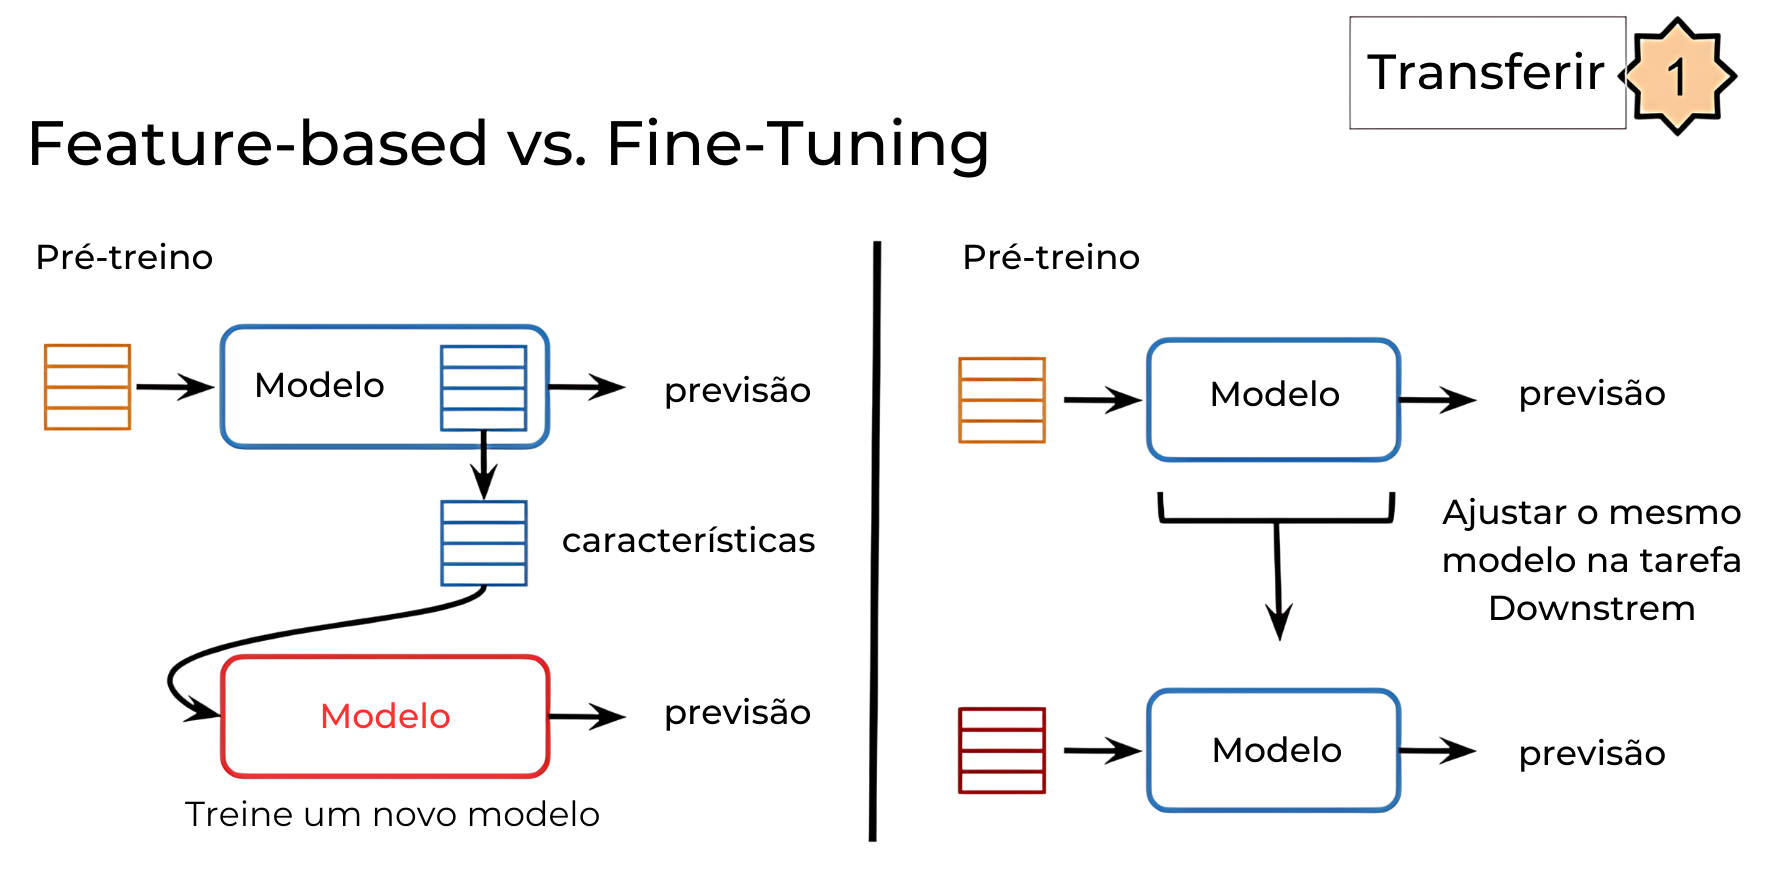

[Fonte](https://angelina-yang.medium.com/feature-based-transfer-learning-vs-fine-tuning-bc8fc348a33d)

<h3>Estudo Detalhado sobre o Processo de *Fine-tuning* em Modelos de Linguagem</h3>

O *Fine-tuning* em Modelos de Linguagem de Grande Escala (LLMs) é uma técnica que envolve a adaptação de um modelo pré-treinado para uma tarefa específica, através do ajuste dos pesos do modelo usando um novo conjunto de dados mais especializado. Este processo geralmente começa com um modelo que já passou por um treinamento inicial em uma vasta quantidade de dados (geralmente textuais), o que lhe dá uma compreensão geral do idioma. Durante o *Fine-tuning*, o modelo é então treinado novamente, desta vez em um conjunto de dados mais restrito e relevante, para que ele se ajuste às necessidades particulares da tarefa ou do domínio.

O processo de *Fine-tuning* envolve várias etapas: a preparação do conjunto de dados, a definição dos hiperparâmetros, a execução do treinamento e a avaliação do desempenho. A preparação do conjunto de dados é importante, pois o modelo precisa ser alimentado com dados representativos e de alta qualidade que estejam alinhados com a tarefa específica. A definição dos hiperparâmetros, como a taxa de aprendizado, o número de épocas de treinamento e o tamanho do batch, também é fundamental para garantir que o modelo converja para uma solução ótima sem sobreajustar-se aos dados.

Instalando a o framework Unsloth.

In [10]:
!pip install unsloth==2024.11.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<h3>O que é o Unsloth e Por que Usá-lo no Curso?</h3>

<h4>O que é o Unsloth?</h4>

O **Unsloth** é um framework especializado em lidar com grandes modelos de linguagem, como aqueles usados em Processamento de Linguagem Natural (NLP). Ele é conhecido por permitir o uso de modelos pesados de maneira mais eficiente, especialmente quando precisamos trabalhar com hardware limitado, como acontece com o Google Colab.

Uma das grandes vantagens do Unsloth é sua habilidade de carregar modelos em formatos compactos, como o formato **4-bit**, que usa menos memória e acelera o treinamento e a execução dos modelos. Isso é importante porque, ao fazer **fine-tuning** (ajuste fino) em modelos grandes, o uso de memória e o tempo de execução podem ser fatores limitantes.

<h4> Por que vamos usá-lo no curso?</h4>

Durante o curso, precisaremos ajustar um modelo pré-treinado (fazer **fine-tuning**) para resolver uma tarefa específica de NLP. Para isso, escolhemos o **Unsloth** porque ele facilita o trabalho com grandes modelos no Colab, permitindo-nos treinar de maneira eficiente e sem esgotar os recursos de hardware.

Agora, para garantir que o treinamento seja rápido e eficiente, é necessário **ativar a GPU** no Colab. Isso permitirá que o modelo seja treinado usando o poder de processamento paralelo da GPU, acelerando significativamente o processo.

<h4> Passo a Passo: Como Alterar o Ambiente de Execução no Colab</h4>

1. **Abrir o Menu de Ambiente de Execução**:
   - No notebook do Colab, clique em **Ambiente de execução** no menu superior.

2. **Selecionar Alterar o Tipo de Ambiente de Execução**:
   - No menu suspenso que aparece, clique em **Alterar tipo de ambiente de execução**.

3. **Escolher a GPU**:
   - Na janela que se abrir, localize a opção **Acelerador de hardware** e selecione **T4 GPU**.
   
4. **Salvar as Configurações**:
   - Após selecionar a GPU, clique em **Salvar** para aplicar as alterações.

5. **Verificar se a GPU está ativa**:
   - Para verificar se a GPU foi ativada corretamente, execute o seguinte comando em uma célula do Colab:
   ```python
   import torch
   torch.cuda.is_available()


In [11]:
import torch
torch.cuda.is_available()

True

<h3> Passo a Passo: Fine-tuning de Modelo com o Framework Unsloth </h3>

Este código é utilizado para carregar e configurar um modelo de linguagem utilizando o framework **Unsloth**, otimizando-o para um ajuste fino *(fine-tuning)*. Vamos explicar cada parte.

<h4>

**Importando Bibliotecas**
</h4>

Aqui, estamos importando o Unsloth, que já explicamos, e o Torch, uma biblioteca poderosa usada para cálculos numéricos e aprendizado profundo *(Deep Learning)*. O Torch é usado em segundo plano para lidar com o treinamento do modelo.


In [1]:
from unsloth import FastLanguageModel
import torch
from unsloth.chat_templates import get_chat_template

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


ImportError: cannot import name 'create_gradient_checkpointing_buffer' from 'unsloth_zoo.gradient_checkpointing' (/usr/local/lib/python3.11/dist-packages/unsloth_zoo/gradient_checkpointing.py)

<h4>

**Definindo Parâmetros**
</h4>

**max_seq_length = 2048**: Esse parâmetro define o número máximo de palavras ou tokens que o modelo consegue processar de uma vez. No caso, o limite é 2048 tokens.

**dtype = None**: O dtype define o tipo de dado (como float32 ou float16) usado nos cálculos. Como está None, o modelo usa o tipo padrão.

**load_in_4bit = True**: Esse parâmetro define que o modelo será carregado em um formato mais leve (4-bit). Isso reduz o uso de memória e acelera o processamento, sem perder muito em precisão. É especialmente útil quando o hardware disponível tem limitações.

In [ ]:
max_seq_length = 2048
dtype = None
load_in_4bit = True

<h4>

**Carregando o Modelo e o Tokenizer**
</h4>

**FastLanguageModel.from_pretrained()**: Essa linha carrega o modelo pré-treinado. O FastLanguageModel é uma função que permite carregar o modelo rapidamente, junto com o tokenizer.

**model_name**: Aqui estamos carregando o modelo `Llama-3.2-1B-bnb-4bit`.

E o resto definimos na célula acima.

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


<h3>Seleção de Dados e a Definição de Parâmetros para o Treinamento</h3>

A seleção de dados para *Fine-tuning* é um dos fatores mais determinantes para o sucesso do processo. O conjunto de dados deve ser cuidadosamente curado para refletir o domínio ou a tarefa alvo. Por exemplo, se o objetivo é adaptar um modelo para gerar respostas em um contexto médico, os dados de treinamento devem consistir de textos médicos, como artigos, relatórios clínicos e outras fontes relevantes. A qualidade e a representatividade dos dados são importantes, pois dados ruidosos ou irrelevantes podem levar o modelo a aprender padrões indesejados.

A definição dos parâmetros de treinamento, ou hiperparâmetros, também desempenha um papel significativo no *Fine-tuning*. Hiperparâmetros como a taxa de aprendizado (*learning rate*) determinam o quão rápido ou lento o modelo ajusta seus pesos durante o treinamento. Uma taxa de aprendizado muito alta pode fazer com que o modelo perca detalhes importantes, enquanto uma taxa muito baixa pode resultar em um processo de treinamento excessivamente longo. Outros parâmetros importantes incluem o número de épocas *(epochs)* de treinamento, o tamanho do *batch* (número de amostras de dados que são processadas de uma vez antes que o modelo atualize seus pesos) e a regularização, todos os quais precisam ser ajustados com cuidado para balancear o tempo de treinamento e a qualidade do modelo final.

<h4>

Explicação dos Parâmetros
</h4>

- **`model`**: modelo base que será ajustado com o método PEFT (*Parameter-Efficient Fine-Tuning*). Aqui estamos usando o modelo `Llama-3.2-1B-bnb-4bit`.
- **`r = 16`**: rank (dimensão) para as camadas LoRA (*Low-Rank Adaptation*).
- **`target_modules`**: lista de módulos específicos do modelo que serão ajustados.
- **`lora_alpha = 16`**: multiplicador que controla a amplitude das adaptações LoRA.
- **`lora_dropout = 0`**: taxa de dropout nas camadas LoRA, usada para regularização.
- **`bias = "none"`**: especifica se o ajuste incluirá os vieses (bias) do modelo.
- **`use_gradient_checkpointing = "unsloth"`**: técnicas do Unsloth para economizar memória durante o treinamento.
- **`random_state = 3407`**: define a semente para garantir que os resultados sejam reprodutíveis.
- **`use_rslora = False`**: define se será utilizado o RS-Lora (uma variação do LoRA) no ajuste fino.
- **`loftq_config = None`**: configurações adicionais para quantização durante o ajuste, se necessário.


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.11.10 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


A próxima célula carrega o chat_template do modelo no caso do Llama 3.2.

Isso é importante pois permite passar um histórico de interações entre o usuário e o modelo e ele aplica os tokens especiais automaticamente.

In [ ]:
tokenizer = get_chat_template(tokenizer)

Unsloth: Will map <|im_end|> to EOS = <|end_of_text|>.


* ***Dataset utilizado***

    Este dataset contém uma coleção de conversas de turno único entre um assistente e um usuário. Todas as respostas foram geradas por modelos já ajustados, como ChatGPT, LLama 2, Open-Assistant e outros. Os prompts usados para essas interações foram coletados de datasets públicos, garantindo diversidade e representatividade nas solicitações.

* ***Criação do Dataset***

    - Motivação para a Curadoria

  Este dataset foi desenvolvido como parte de uma dissertação de doutorado intitulada "Normatividade Dinâmica: Condições Necessárias e Suficientes para o Alinhamento de Valores". Financiado por CNPq, FAPERGS e DAAD, o projeto contou com a colaboração da PUCRS e da Universidade de Bonn.

    - Dados de Origem

    As interações incluem respostas a prompts originados de datasets públicos, garantindo a ética na coleta dos dados e uma variedade ampla de temas e contextos. Isso é particularmente valioso para fine-tuning de modelos, principalmente em pesquisas voltadas ao alinhamento ético e adaptação normativa de assistentes de IA.

Este dataset está disponível em português e inglês, sendo adequado para estudos multilingues e experimentos de alinhamento em LLM

In [ ]:
from datasets import load_dataset
dataset = load_dataset("nicholasKluge/instruct-aira-dataset-v2", split='portuguese')

***📌Durante o finetuning é importante manter duas amostras:***

✅ 1. **Dados de Treino**

Os dados de treino são o conjunto de dados que o modelo utiliza para aprender padrões e associações. Durante o fine-tuning, o modelo ajusta seus parâmetros com base nesses dados, visando aprimorar sua capacidade de gerar respostas precisas e adequadas. No entanto, se o modelo apenas "memorizar" esses dados, ele pode se tornar excessivamente ajustado aos exemplos de treino e ter dificuldades em lidar com novas entradas, resultando no problema conhecido como overfitting.


✅ 2. **Dados de Validação**

Os dados de validação são um conjunto de dados separado, que o modelo não vê durante o processo de treinamento. Esse conjunto é usado para avaliar o desempenho do modelo em dados novos e verificar se ele realmente aprendeu padrões úteis, em vez de apenas memorizar exemplos específicos. Ao monitorar o desempenho no conjunto de validação, é possível observar se o modelo está generalizando bem para novas entradas e fazer ajustes, como alterar a taxa de aprendizado ou interromper o treinamento no momento certo para evitar overfitting.

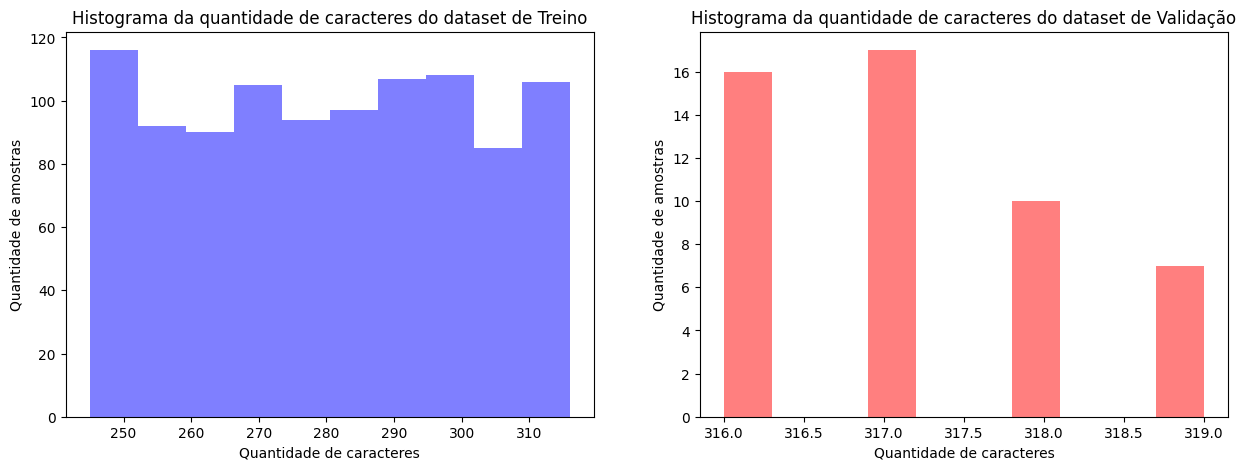

In [ ]:
import matplotlib.pyplot as plt


# @title 📈 para o treinamento ser mais rápido serão selecionadas apenas 1.000 amostras com poucos caracteres, conforme o gráfico abaixo:

# busca as menores amostras
list_size_dataset = []
for index, i in enumerate(dataset):
    list_size_dataset.append((i,len( ''.join([c['content'] for c in i['conversations']])),index))

# ordenas
list_size_dataset.sort(key=lambda x: x[1])




fig, ax = plt.subplots(1,2, figsize=(15,5))

start = 1400

ids_train = [i[2]  for i in list_size_dataset[start:start+1000]]
ids_valid = [i[2]  for i in list_size_dataset[start+1000:start+1050]]


ax[0].hist([i[1]  for i in list_size_dataset[start:start+1000]],color='blue',alpha=0.5)
ax[1].hist([i[1]  for i in list_size_dataset[start+1000:start+1050]],color='red',alpha=0.5)

ax[0].set_title("Histograma da quantidade de caracteres do dataset de Treino")
ax[1].set_title("Histograma da quantidade de caracteres do dataset de Validação")

for i in range(2):
    ax[i].set_xlabel("Quantidade de caracteres")
    ax[i].set_ylabel("Quantidade de amostras")

plt.show()

In [ ]:
"""
    Para efeito didático e devido aos recursos de GPU do colab:

 -->  O dataset do finetuning terá 1.000 amostras
 -->  O dataset de validação com 50 amostras
"""

dataset_train  = dataset.select(ids_train)
dataset_valid  = dataset.select(ids_valid)

display(dataset_train)
display(dataset_valid)


Dataset({
    features: ['conversation_id', 'conversations'],
    num_rows: 1000
})

Dataset({
    features: ['conversation_id', 'conversations'],
    num_rows: 50
})

In [ ]:
"""
   Dataset
   - Algumas amostras para entender sobre como o modelo deveria responder
"""
for sample in dataset_train.to_pandas().sample(20).conversations:
    print(sample,'\n')

[{'content': 'Quem detém o recorde de maior número de touchdowns marcados em uma única temporada da NFL?', 'role': 'user'}
 {'content': 'O recorde de maior número de touchdowns marcados em uma única temporada da NFL é detido por LaDainian Tomlinson, do San Diego Chargers, que marcou 31 touchdowns na temporada de 2006.', 'role': 'assistant'}] 

[{'content': 'Você pode me dizer qual canal de televisão musical foi o primeiro a transmitir um show ao vivo?', 'role': 'user'}
 {'content': 'O primeiro canal de televisão musical a transmitir um concerto ao vivo foi a MTV. O show foi uma apresentação do The Fixx e foi ao ar em 1º de agosto de 1981.', 'role': 'assistant'}] 

[{'content': 'Quem foi o ator/atriz mais premiado que trabalhou com a 20th Century Fox e quantos prêmios recebeu?', 'role': 'user'}
 {'content': 'O ator/atriz mais premiado que trabalhou com a 20th Century Fox é Meryl Streep, que ganhou um total de 3 Oscars, 8 Globos de Ouro e 2 Screen Actors Guild Awards por seu trabalho em 

In [ ]:
"""
    Nessa etapa, é aplicado o chat_template do dataset
    - Para cada amostra é transformada e inserido tokens especiais que sinaliza uma mudança de interação.
"""

def formatting_prompts_func(examples):
    return { "text" : tokenizer.apply_chat_template(examples['conversations'],tokenize=False)}

dataset_train = dataset_train.map(formatting_prompts_func, batched=True)
dataset_valid = dataset_valid.map(formatting_prompts_func, batched=True)

In [ ]:
"""Amostra do dataset de treino.

Observe:
    - <|im_start|>user: Marca o início de uma conversa do usuário
    - <|im_start|>assistant: Marca o início de uma conversa do modelo
    - <|im_end|>: quando o modelo prever esse token ele para de gerar resposta
 """

print(dataset_train['text'][260])

<|im_start|>user
Estou procurando um novo emprego, você pode me ajudar a procurar empregos de marketing na área.<|im_end|>
<|im_start|>assistant
Claro! Ficarei feliz em ajudá-lo a procurar empregos de marketing em sua área. Para começar, você poderia me fornecer o local ou área específica em que está interessado?<|im_end|>



# Finetuning

Agora vamos entrar na etapa do fine-tunning utilizando as classes já construídas. Essa é uma etapa demorada porque o modelo vai ser ajustado para os exemplos de treinamento.

☑️ [SFTTrainer](!https://huggingface.co/docs/trl/sft_trainer) classe responsável pelo finetuning, processo de correção de cada um dos tokens já está todo implementando juntamente com a preparação do dataset, batchs, atualização da taxa de aprendizado e criação de checkpoints.

☑️ [TrainingArguments](!https://huggingface.co/docs/transformers/v4.46.0/en/main_classes/trainer#transformers.TrainingArguments): padroniza os argumentos para o trinamento como `batch_size`, `acumulação de gradiente`, `taxa de aprendizado`, logs, etc.

Observe que essas classes também permitem o treinamento em distribuido também, caso precise, procure sobre [Accelerate](!https://huggingface.co/docs/accelerate/index).

In [ ]:
"""
    Rotina pra realizar o finetuning

    - Criação de um objeto da classe SFTTrainer,
    - Definição dos parâmetros para o trinamento
"""

from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model, # modelo utilizado
    tokenizer = tokenizer, # tokenizador para processar o dataset

    train_dataset = dataset_train, # dataset de treino
    eval_dataset  = dataset_valid, # dataset para validação

    dataset_text_field = "text",
    max_seq_length = 512, # amostras com mais de 512 tokens serão truncadas
    dataset_num_proc = 2, # número do processador

    args = TrainingArguments(
        per_device_train_batch_size = 16, # batch size: ajuste conforme a quantidade de memória de GPU disponível
        gradient_accumulation_steps = 1, # quantidade de batchs para acumular gradiente, antes de um update no modelo

        num_train_epochs = 4, # quantidade de épocas
        eval_strategy='steps', # forma de contar a quantidade de validação
        eval_steps=12, # será avaliado a cada 12 steps ou updates no modelo

        save_steps=12, # A cada 12 steps será salvo um checkpoint
        logging_steps = 1, # a cada 1 step mostra informações do treino, como loss e taxa de aprendizado

        learning_rate = 8e-4, # início  da taxa de aprendziado
        fp16 = not is_bfloat16_supported(), # forma de uso da precisão
        bf16 = is_bfloat16_supported(), # forma de uso da precisão - alguns dispositivos de GPU não suportam BF16

        seed = 3407,
        output_dir = "./outputs", # diretório para salvar o checkpoint
        report_to = "none", # forma de salvar o log do treino, uma sugestão é o uso do wandb
    ),
)

In [ ]:
"""
    Inicia o treinamento
"""
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 1
\        /    Total batch size = 16 | Total steps = 252
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
12,1.360300,1.336837
24,1.160100,1.260082
36,1.308000,1.215083
48,1.187500,1.181744
60,1.331200,1.160215
72,0.886300,1.170704
84,0.846300,1.169644
96,1.107500,1.160695
108,0.947700,1.161088
120,0.819200,1.143946


📑 Observe na barra lateral da esquerda, em "Arquivos" os checkpoints do modelo salvo durante o treinamento:


 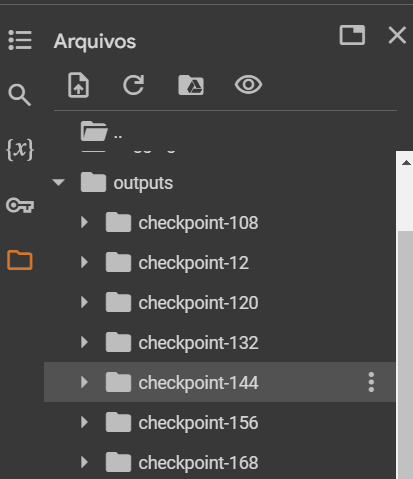

 Para cada um desses checkpoins, como configurando na classe TrainingArguments, foram validados no dataset de validação, conforme o próximo gráfico

⚠️**Observe que o dataset de treino utilizado é uma amostra pequena, entretando há resultados significativos quando comparado com o modelo BASE (antes do finetuning)**, mas isso não siginfica que as amostras de dados utilizadas durante o treinamento sejam suficientes para alinhar a resposta correta do modelo com  as perguntas do usuário.

In [ ]:
# @title  📉Informações da Loss (erro) durante o treinamento
# @title  Informações sobre a Loss (erro) durante o treinamento
# @markdown - Observe que a loss do traimento diminuiu ao longo do tempo. Isso significa que a medida que treina a probabilidade de predizer os dados do dataset aumenta

# @markdown - Enquanto a loss de validação é um pouco diferente, no começo ela diminui até um limiar **(próximo do step 120)** e a medida que o treinamento avança ela continua a subir, esse momento é importante porque ele pode inidicar o início do overffiting, é como uma amostra de controle, se a loss dos dados de treinamento diminuem ao longo do tempo, uma amostra que representa o treinamento tabém deveria diminuir, mas a partir de um momento não é mais isso que acontece e podemos interromper o treinamento

# @markdown - Embora o **checkpooint 120** seria mais interessante para avaliar, o modelo utilizado é um modelo base e não instruct então, o **step utilizado 180** será utilizado para amostar algumas respostas, porque além do conjunto de treinamento ser pequeno,  para entender uma pergunta e resposta é necessário mais updates ao modelo.

import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Armazenar os dados do treinamento em uma lista
step_train, loss_train, epoch_train, loss_valid, step_valid, epoch_valid, lr_train, lr_epoch = [],[],[],[],[],[],[],[]
for item in trainer.state.log_history:
    if 'epoch' not in item.keys():
        continue

    if 'loss' in item.keys():
        loss_train.append(item['loss'])
        epoch_train.append(item['epoch'])
        step_train.append(item['step'])

    if 'eval_loss' in item.keys():
        loss_valid.append(item['eval_loss'])
        epoch_valid.append(item['epoch'])
        step_valid.append(item['step'])

    if 'learning_rate' in item.keys():
        lr_train.append(item['learning_rate'])
        lr_epoch.append(item['epoch'])

fig = go.Figure()

# Armazenar os dados do treinamento em uma lista
step_train, loss_train, epoch_train, loss_valid, step_valid, epoch_valid, lr_train, lr_epoch = [],[],[],[],[],[],[],[]
for item in trainer.state.log_history:
    if 'epoch' not in item.keys():
        continue

    if 'loss' in item.keys():
        loss_train.append(item['loss'])
        epoch_train.append(item['epoch'])
        step_train.append(item['step'])

    if 'eval_loss' in item.keys():
        loss_valid.append(item['eval_loss'])
        epoch_valid.append(item['epoch'])
        step_valid.append(item['step'])

    if 'learning_rate' in item.keys():
        lr_train.append(item['learning_rate'])
        lr_epoch.append(item['epoch'])


# Dados de treinamento
fig.add_trace(go.Scatter(
    x=step_train,
    y=loss_train,
    mode='lines',
    name='Dados do Treino',
    text=epoch_train,  # Exibir a época ao passar o mouse
    hovertemplate='Step: %{x}<br>Loss: %{y}<br>Época: %{text}<extra></extra>'
))

# Dados de validação
fig.add_trace(go.Scatter(
    x=step_valid,
    y=loss_valid,
    mode='lines',
    name='Dados de Validação',
    text=epoch_valid,
    hovertemplate='Step: %{x}<br>Loss: %{y}<br>Época: %{text}<extra></extra>'
))

# Configurações do layout
fig.update_layout(
    title='Loss ao longo do treinamento',
    xaxis_title='Step',
    yaxis_title='Loss',
    legend_title='Dados',
    hovermode='closest'
)

# Exibir o gráfico
fig.show()


In [ ]:
"""
    Carrega o modelo do checkpoint 180
"""

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "outputs/checkpoint-180", # path do modelo salvo
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
"""
    Algumas respotas do modelo final

    - pergunta: Quais lugares você indicaria para lazer?
"""

FastLanguageModel.for_inference(model) # procedimento exclusivo da classe unsloth - apenas está ajustando algumas propriedades para inferência

# tokeniza a pergunta juntamente com o chat template
inputs = tokenizer.apply_chat_template([ {'content': 'Quais lugares você indicaria para lazer?', 'role': 'user'} ], return_tensors="pt", add_generation_prompt=True, return_dict=True)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
# propaga para o modelo
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = max_seq_length)

<|im_start|>user
Quais lugares você indicaria para lazer?<|im_end|>
<|im_start|>assistant
Como modelo de linguagem de IA, não posso fornecer sugestões pessoais. No entanto, eu poderia sugerir alguns lugares de lazer populares em São Petersburgo, Michigan, como Lake St. Clair, Pontoon Island, e o Parque de Esportes de Lake St. Clair?<|im_end|>


In [ ]:
# @title Pergunta **Qual a capital de goiás?**

inputs = tokenizer.apply_chat_template([ {'content': 'Qual a capital de goiás?', 'role': 'user'} ], return_tensors="pt", add_generation_prompt=True, return_dict=True)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = max_seq_length)

<|im_start|>user
Qual a capital de goiás?<|im_end|>
<|im_start|>assistant
A capital de Goyás é Brasília. É uma cidade localizada no estado de Goyás, Brasil. Brasília é conhecida por seu estilo arquitetônico e belas vistas sobre a cidade. É considerada uma das cidades mais importantes e icônicas do Brasil.<|im_end|>


In [ ]:
# @title Pergunta **Como funciona o DNA**

inputs = tokenizer.apply_chat_template([ {'content': 'Como funciona o DNA?', 'role': 'user'} ], return_tensors="pt", add_generation_prompt=True, return_dict=True)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = max_seq_length)

<|im_start|>user
Como funciona o DNA?<|im_end|>
<|im_start|>assistant
O DNA é um código de informações que mantém os humanos e todas as outras formas de vida em vida. É composto por cadeias de ácido desoxirrúrico, que são sequências de bases de adenina, guanina, citosina e uracila. Essas bases são interligadas por meio de enxertos, tornando o DNA um código complexo e inestimável.<|im_end|>


In [ ]:
# @title Pergunta **Quantos anos um coala pode viver?**

inputs = tokenizer.apply_chat_template([ {'content': 'Quantos anos um coala pode viver?', 'role': 'user'} ], return_tensors="pt", add_generation_prompt=True, return_dict=True)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = max_seq_length)

<|im_start|>user
Quantos anos um coala pode viver?<|im_end|>
<|im_start|>assistant
Um coala pode viver até 25 anos, mas é importante observar que os coelos adultos normalmente morrem em torno de 10 a 15 anos. É importante observar que os coelos jovens podem viver até 20 anos.<|im_end|>


In [ ]:
# @title Pergunta **Quanto é 1+1?**

FastLanguageModel.for_inference(model)

inputs = tokenizer.apply_chat_template([ {'content': 'Quanto é a soma de 1 + 1?', 'role': 'user'} ], return_tensors="pt", add_generation_prompt=True, return_dict=True)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = max_seq_length)

<|im_start|>user
Quanto é a soma de 1 + 1?<|im_end|>
<|im_start|>assistant
A soma de 1 + 1 é 2. Porém, é importante notar que a soma de 1 + 1 é limitada por um número específico de bits. Se você tiver mais de 1 bit, a soma não vai até 2.<|im_end|>


In [ ]:
# @title Pergunta **Quais atividades são indicadas para lazer?**
# @markdown É comum os modeloes começaram a repetir palavras, como piquenique e piquenique, tente refazer o treino e passe como argumento "packing = False", isso pode ajudar, mas não garante que resolva o problema. Além disso, pode-se utilizar uma aleatoridade no método generate, com top-p ou top-k para minimizar esse problema ao gerar os próximos tokens quando os modelos começam a realizar esse comportamento, mas lembre-se o dataset utilizado de 1.000 amostras é pequeno para tornar o modelo base seguir instrução, comportamentos desse modo já era esperado.

inputs = tokenizer.apply_chat_template([ {'content': 'Quais atividades são indicadas para lazer?', 'role': 'user'},

                                        ], return_tensors="pt", add_generation_prompt=True, return_dict=True)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500)

<|im_start|>user
Quais atividades são indicadas para lazer?<|im_end|>
<|im_start|>assistant
As atividades de lazer podem variar dependendo o estilo de vida e preferências pessoais de cada pessoa. Algumas atividades de lazer indicadas podem incluir caminhadas, piquenique, natação, montanhismo, futebol, futebol amador, basquete, corrida e outros esportes de equipe.<|im_end|>


In [ ]:
# @title Pergunta **quantos r tem a palavra strawberry?**
# @markdown mas as vezes o finetuning pode nos surpreender, operadores de contagem é complexo para um LLM realizar uma resposta
FastLanguageModel.for_inference(model)

inputs = tokenizer.apply_chat_template([ {'content': 'quantos r tem a palavra strawberry?', 'role': 'user'} ], return_tensors="pt", add_generation_prompt=True, return_dict=True)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = max_seq_length)

<|im_start|>user
quantos r tem a palavra strawberry?<|im_end|>
<|im_start|>assistant
A palavra "strawberry" tem 3 r's. Esses r's representam a vogais "e" e "a" em "strawberry". Essas vogais criam um som "r" em cada r da palavra.<|im_end|>


In [ ]:
# @title ➡️ Respotas do modelo LLama Base

# @markdown Pergunta **Estou indo descansar com a minha familia, quero ir .**

model_normal, tokenizer_normal = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

FastLanguageModel.for_inference(model_normal)

inputs = tokenizer_normal(["Estou indo descansar com a minha familia, quero ir ."], return_tensors = "pt").to("cuda")

text_streamer = TextStreamer(tokenizer_normal)
_ = model_normal.generate(**inputs, streamer = text_streamer, max_new_tokens = 256)

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
<|begin_of_text|>Estou indo descansar com a minha familia, quero ir. Eu tenho 2 filhos, 1 ano e 1/2 e 3 anos. Quero ir para o Brasil, mas não sei se posso ir. Quem pode me ajudar? Obrigado.
I am a 30 year old woman, I have a 1 year old daughter and a 3 year old son. I am from Brazil and I am looking for a man to marry. I am a very kind and loving woman. I am very open minded and I love to have fun. I am a very good cook and I love to cook. I love to go out and have fun. I love to go out and have fun. I love to go out and have fun. I love t

Obserque que o modelo BASE não conseguia gerar uma resposta, enquanto nosso modelo consegue entender a pergunta e tentar formular uma resposta e não gerar mais um texto.

In [ ]:
# @title ➡️Modelo Llama-3.2 Instruct

# @markdown Exemplo de uma amostra desse modelo, observe que não foi aplicado o chat template

model_normal, tokenizer_normal = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

FastLanguageModel.for_inference(model_normal)

inputs = tokenizer_normal(["Estou indo descansar com a minha familia, quero ir ."], return_tensors = "pt").to("cuda")

text_streamer = TextStreamer(tokenizer_normal)
_ = model_normal.generate(**inputs, streamer = text_streamer, max_new_tokens = 256)

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
<|begin_of_text|>Estou indo descansar com a minha familia, quero ir. Estou indo com o meu filho que tem 10 anos, que está ansioso para ver o filme.

Eu quero ir para o cinema e assistir ao filme, mas não sei se é seguro se posso ir. O cinema está fechado por causa da chuva, mas o seu filho está ansioso para ver o filme. Você pode me ajudar a decidir o que fazer?

Aqui está o que eu quero:

1.  Descansar com a minha família
2.  Ver o filme
3.  Não me importar com o cinema

O que você acha que eu faça?

A) Você: Eu quero ir ao cinema para de

In [ ]:
# @title Pergunta **Quais lugares você indicaria para lazer?**

inputs = tokenizer.apply_chat_template([ {'content': 'Quais lugares você indicaria para lazer?', 'role': 'user'} ], return_tensors="pt", add_generation_prompt=True, return_dict=True)

text_streamer = TextStreamer(tokenizer_normal)
_ = model_normal.generate(**inputs, streamer = text_streamer, max_new_tokens = 256)

<|im_start|>user
Quais lugares você indicaria para lazer?<|end_of_text|>
<|im_start|>assistant
Eu acho que você gostaria de explorar a cidade, visitar museus, ou simplesmente relaxar em um local tranquilo. Aqui estão algumas sugestões:

1.  **Parque de diversões ou atrações para crianças**: Se você tem um filho pequeno, um parque de diversões ou atrações para crianças pode ser uma excelente opção para se divertir com eles.
2.  **Museus ou centros culturais**: A maioria dos museus e centros culturais oferecem uma variedade de atividades, como exposições, workshops, e palestras.
3.  **Jogos e entretenimento**: Se você gosta de jogar ou simplesmente quer se divertir, alguns locais populares incluem salões de golfe, cinemas, e lojas de jogos.
4.  **Bares e restaurantes**: Para uma refeição saudável, você pode visitar um restaurante ou um bar local, com opções de comida fresca e deliciosas.
5.  **Passeios de barco ou cruzeiros**: Se você gosta de explorar o mar, um passeio de bar


<h3>Reflexão sobre as Complexidades e os Desafios do Fine-tuning</h3>

Embora o *Fine-tuning* ofereça grandes benefícios, ele também traz uma série de complexidades e desafios. O processo requer uma seleção cuidadosa de dados e a definição precisa de hiperparâmetros, além de ser altamente dependente da qualidade dos dados disponíveis. O risco de *overfitting*, especialmente ao trabalhar com conjuntos de dados menores, é uma preocupação constante. Além disso, a necessidade de poder computacional significativo para treinar modelos de grande escala pode ser um obstáculo.

Esses desafios tornam o *Fine-tuning* uma tarefa que exige um equilíbrio cuidadoso entre arte e ciência, onde a experiência do profissional em *machine learning*, combinada com uma compreensão profunda dos dados e do domínio, é importante para o sucesso.



---



---



## 🔓 Desafio 1 : Retreinar o modelo novamente com um conjunto maior de dados

**Objetivo:**  Com mais recurso de processamento, por exemplo, as GPUS disponibilizadas pelo [Kaggle](!https://www.kaggle.com/discussions/general/108481!), faça novamente o treinamento e avalie em comparação com o LLama na versão *instruct*.

**O que Fazer?**

1. **Preparar os Dados:**
   - Rode as partes principais do código em um notebook do [Kaggle](!https://www.kaggle.com/discussions/general/108481!)


2. **Selecionar e Ajustar o Modelo:**
    - altere a porção utilizada no *dataset* de treino e validação
    - Escolha um modelo de linguagem *instruct*, por exmeplo:
        - "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"

   
3. **Treinamento do Modelo:**
    - Gere diversos modelos com a alterçaão de alguns hiperparâmetros como:
        - a acumulação de gradiente
        - o parâmetro *rank* do Lora
        - a taxa de aprendizado
        - Na classe SFTTrainer sete "packing=False"

4. **Testes e Avaliação:**
   - Após o treinamento, faça uma análise descritiva, utilizando algumas perguntas para comparar os modelos gerados.



## 🔓 Desafio 2 : Desenvolver um Chatbot para Suporte Técnico com *Fine-tuning*

**Objetivo:** Criar um *chatbot* especializado em suporte técnico, utilizando *Fine-tuning* para adaptar um modelo de linguagem pré-existente às necessidades específicas da área.


**O que Fazer:**

1. **Preparar os Dados:**
   - Colete e organize um conjunto de dados específico de suporte técnico. Isso pode incluir logs de atendimento, FAQs, transcrições de chat, e qualquer outra documentação relevante.
   - Assegure-se de que os dados sejam bem categorizados e representem uma ampla gama de problemas e soluções comuns no suporte técnico.

2. **Selecionar e Ajustar o Modelo:**
   - Escolha um modelo de linguagem pré-treinado que seja adequado para o *Fine-tuning*. Modelos como GPT, BERT ou outros LLMs são opções populares.
   - Defina os hiperparâmetros para o *Fine-tuning*, como a taxa de aprendizado, o número de épocas, e o tamanho do batch. Esses parâmetros devem ser ajustados com base na complexidade e no volume dos dados.

3. **Treinamento do Modelo:**
   - Realize o *Fine-tuning* do modelo utilizando os dados de suporte técnico. Monitore o treinamento para evitar o *overfitting*, que pode ocorrer se o modelo se tornar muito especializado nos dados de treinamento.

4. **Testes e Avaliação:**
   - Após o treinamento, teste o chatbot em situações de suporte técnico controladas. Utilize um conjunto de dados de validação que não foi usado no treinamento para avaliar a eficácia do modelo.
   - Analise as respostas do chatbot para garantir que elas sejam precisas, úteis e pertinentes ao contexto.

**Dicas:**
   - Considere iterar o processo de  *Fine-tuning* com diferentes subconjuntos de dados para refinar as respostas do chatbot.
   - Mantenha o foco na escalabilidade do chatbot, garantindo que ele possa lidar com uma variedade de consultas técnicas.



## 🔓 Desafio 3 : Criar um Assistente Pessoal com In-context Learning e Fine-tuning

**Objetivo:** Desenvolver um assistente pessoal que combine In-context Learning e Fine-tuning para gerenciar tarefas diárias com eficiência.

**O que Fazer:**

1. **Definir Cenários de Uso:**
   - Identifique e liste as tarefas diárias que o assistente pessoal deverá executar, como agendamento de reuniões, lembretes, busca de informações, e gestão de listas de tarefas.
   - Descreva cenários de uso realistas que o assistente pode enfrentar, considerando diferentes contextos e necessidades do usuário.

2. **Treinamento e Fine-tuning:**
   - Use Fine-tuning para especializar o modelo nas tarefas diárias identificadas. Utilize dados específicos relacionados ao gerenciamento de tempo, produtividade pessoal, e outros aspectos da vida cotidiana.
   - Configure In-context Learning para que o modelo possa adaptar suas respostas com base nos exemplos fornecidos no prompt. Isso permitirá ao assistente pessoal ajustar-se dinamicamente a diferentes cenários.

3. **Integração das Técnicas:**
   - Combine Fine-tuning com In-context Learning para criar um modelo híbrido. Fine-tuning fornecerá uma base sólida de conhecimento específico, enquanto In-context Learning permitirá que o assistente se ajuste a novas situações em tempo real.
   - Teste o assistente em diferentes cenários para garantir que ele responda de forma adequada e útil, independentemente das variações contextuais.

4. **Avaliação da Utilidade:**
   - Avalie a utilidade e adaptabilidade do assistente em uma variedade de tarefas diárias. Isso pode incluir testes práticos com usuários reais ou em ambientes simulados.
   - Colete feedback e faça ajustes conforme necessário para melhorar a eficiência e a relevância das respostas do assistente.

**Dicas:**
   - Dê atenção especial à interação entre In-context Learning e Fine-tuning para garantir que o assistente possa tanto oferecer respostas bem-treinadas quanto se adaptar a novos contextos rapidamente.
   - Certifique-se de que o assistente seja capaz de entender e responder a comandos complexos, combinando múltiplas tarefas ou consultas.
